<a href="https://colab.research.google.com/github/eimran/colab_test/blob/main/PNN_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!git clone https://github.com/eimran/colab_test.git

fatal: destination path 'colab_test' already exists and is not an empty directory.


In [6]:
!git status

fatal: not a git repository (or any of the parent directories): .git


In [8]:
import torch
import torch .nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# --------------------------
# 1. Generate Synthetic Data
# --------------------------

# Physics parameters
g = 9.7        # acceleration due to gravity
h0 = 1.0       # initial height
v0 = 10.0      # initial velocity

# True (analytical) solution h(t) = h0 + v0*t - 0.5*g*t^2
def true_solution(t):
    return h0 + v0*t - 0.5*g*(t**2)

# Generate some time points
t_min, t_max = 0.0, 2.0
N_data = 10
t_data = np.linspace(t_min, t_max, N_data)

# Generate synthetic "experimental" heights with noise
np.random.seed(0)
noise_level = 0.7
h_data_exact = true_solution(t_data)
h_data_noisy = h_data_exact + noise_level*np.random.randn(N_data)

# Convert to PyTorch tensors
t_data_tensor = torch.tensor(t_data, dtype=torch.float32).view(-1, 1)
h_data_tensor = torch.tensor(h_data_noisy, dtype=torch.float32).view(-1, 1)

Define a small feed-forward neural network for h(t)

In [10]:
# --------------------------------------------------------
# 2. Define a small feed-forward neural network for h(t)
# --------------------------------------------------------
class PINN(nn.Module):
    def __init__(self, n_hidden=20):
        super(PINN, self).__init__()
        # A simple MLP with 2 hidden layers
        self.net = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, 1)
        )

    def forward(self, t):
        """
        Forward pass: input shape (batch_size, 1) -> output shape (batch_size, 1)
        """
        return self.net(t)

# Instantiate the model
model = PINN(n_hidden=20)

Helper for Automatic Differentiation

In [11]:
# --------------------------------
# 3. Helper for Automatic Diff
# --------------------------------
def derivative(y, x):
    """
    Computes dy/dx using PyTorch's autograd.
    y and x must be tensors with requires_grad=True for x.
    """
    return torch.autograd.grad(
        y, x,
        grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]

Define the Loss Components (PINN)

In [12]:
# ----------------------------------------
# 4. Define the Loss Components (PINN)
# ----------------------------------------

# We have:
#    (1) Data loss (fit noisy data)
#    (2) ODE loss: dh/dt = v0 - g * t
#    (3) Initial condition loss: h(0) = h0

def physics_loss(model, t):
    """
    Compare d(h_pred)/dt with the known expression (v0 - g t).
    """
    # t must have requires_grad = True for autograd to work
    t.requires_grad_(True)

    h_pred = model(t)
    dh_dt_pred = derivative(h_pred, t)

    # For each t, physics says dh/dt = v0 - g * t
    dh_dt_true = v0 - g * t

    loss_ode = torch.mean((dh_dt_pred - dh_dt_true)**2)
    return loss_ode

def initial_condition_loss(model):
    """
    Enforce h(0) = h0.
    """
    # Evaluate at t=0
    t0 = torch.zeros(1, 1, dtype=torch.float32, requires_grad=False)
    h0_pred = model(t0)
    return (h0_pred - h0).pow(2).mean()

def data_loss(model, t_data, h_data):
    """
    MSE between predicted h(t_i) and noisy measurements h_data.
    """
    h_pred = model(t_data)
    return torch.mean((h_pred - h_data)**2)


Training Setup

In [13]:
# ---------------------------------------
# 5. Training Setup
# ---------------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Hyperparameters for weighting the loss terms
lambda_data = 1.0
lambda_ode  = 1.0
lambda_ic   = 1.0

# For logging
num_epochs = 2000
print_every = 200

Training Loop

In [14]:
# ---------------------------------------
# 6. Training Loop
# ---------------------------------------
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Compute losses
    l_data = data_loss(model, t_data_tensor, h_data_tensor)
    l_ode  = physics_loss(model, t_data_tensor)
    l_ic   = initial_condition_loss(model)

    # Combined loss
    loss = lambda_data * l_data + lambda_ode * l_ode + lambda_ic * l_ic

    # Backprop
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % print_every == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Total Loss = {loss.item():.6f}, "
              f"Data Loss = {l_data.item():.6f}, "
              f"ODE Loss = {l_ode.item():.6f}, "
              f"IC Loss = {l_ic.item():.6f}")

Epoch 200/2000, Total Loss = 0.546743, Data Loss = 0.483366, ODE Loss = 0.025124, IC Loss = 0.038253
Epoch 400/2000, Total Loss = 0.538408, Data Loss = 0.480515, ODE Loss = 0.022946, IC Loss = 0.034947
Epoch 600/2000, Total Loss = 0.532636, Data Loss = 0.479530, ODE Loss = 0.021879, IC Loss = 0.031228
Epoch 800/2000, Total Loss = 0.525374, Data Loss = 0.478858, ODE Loss = 0.020848, IC Loss = 0.025669
Epoch 1000/2000, Total Loss = 0.517724, Data Loss = 0.478709, ODE Loss = 0.020441, IC Loss = 0.018575
Epoch 1200/2000, Total Loss = 0.510206, Data Loss = 0.472607, ODE Loss = 0.022427, IC Loss = 0.015172
Epoch 1400/2000, Total Loss = 0.504268, Data Loss = 0.466516, ODE Loss = 0.024456, IC Loss = 0.013295
Epoch 1600/2000, Total Loss = 0.501432, Data Loss = 0.462415, ODE Loss = 0.026277, IC Loss = 0.012740
Epoch 1800/2000, Total Loss = 0.500940, Data Loss = 0.462469, ODE Loss = 0.025844, IC Loss = 0.012627
Epoch 2000/2000, Total Loss = 0.500637, Data Loss = 0.460634, ODE Loss = 0.027369, IC 

Evaluate the Trained Model

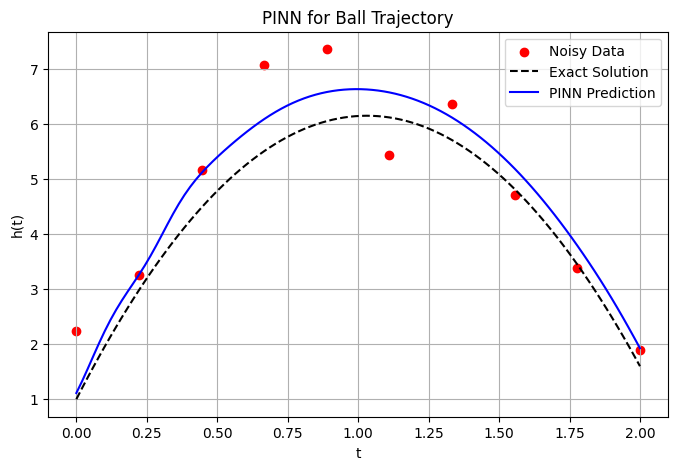

In [15]:
# ---------------------------------------
# 7. Evaluate the Trained Model
# ---------------------------------------
model.eval()
t_plot = np.linspace(t_min, t_max, 100).reshape(-1, 1).astype(np.float32)
t_plot_tensor = torch.tensor(t_plot, requires_grad=True)
h_pred_plot = model(t_plot_tensor).detach().numpy()

# True solution (for comparison)
h_true_plot = true_solution(t_plot)

# Plot results
plt.figure(figsize=(8, 5))
plt.scatter(t_data, h_data_noisy, color='red', label='Noisy Data')
plt.plot(t_plot, h_true_plot, 'k--', label='Exact Solution')
plt.plot(t_plot, h_pred_plot, 'b', label='PINN Prediction')
plt.xlabel('t')
plt.ylabel('h(t)')
plt.legend()
plt.title('PINN for Ball Trajectory')
plt.grid(True)
plt.show()

In [16]:
!git status

fatal: not a git repository (or any of the parent directories): .git


In [17]:
!git add .

fatal: not a git repository (or any of the parent directories): .git


In [18]:
!git clone https://github.com/eimran/colab_test.git

fatal: destination path 'colab_test' already exists and is not an empty directory.


In [19]:
!%cd

/bin/bash: line 1: fg: no job control


In [20]:
!rm -rf colab_test

In [22]:
!git clone https://github.com/eimran/colab_test.git

Cloning into 'colab_test'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7 (delta 1), reused 3 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (7/7), 44.02 KiB | 2.93 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [23]:
%cd colab_test/

/content/colab_test


In [24]:
!git add .

In [25]:
!git commit -m fromColab

Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@97cebc483d38.(none)')


In [27]:
!git config --global user.email "eimran.cse@gmail.com"

In [29]:
!git config --global eimran.name "Imran Masud"

In [30]:
!git commit -m fromColab

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [31]:
!git push origin main

fatal: could not read Username for 'https://github.com': No such device or address


In [32]:
!git push

fatal: could not read Username for 'https://github.com': No such device or address


In [33]:
!git config --global user.name "Imran Masud"

In [34]:
!git add .

In [35]:
!git commit -m fromColab

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [36]:
!git push origin main

fatal: could not read Username for 'https://github.com': No such device or address


In [37]:
%cd colab_test

[Errno 2] No such file or directory: 'colab_test'
/content/colab_test


In [38]:
%cd colab_test/

[Errno 2] No such file or directory: 'colab_test/'
/content/colab_test


In [39]:
!git clone https://github.com/eimran/colab_test.git

Cloning into 'colab_test'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 7 (delta 1), reused 3 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (7/7), 44.02 KiB | 2.75 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [40]:
%cd colab_test/

/content/colab_test/colab_test


In [41]:
!git add .

In [42]:
!git commit -m fromColab

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


In [43]:
!git push origin main

fatal: could not read Username for 'https://github.com': No such device or address


In [45]:
!git config --global user.email "eimran.cse@gmail.com"

In [46]:
!git config --global user.name "eimran"

In [47]:
!git push origin main

fatal: could not read Username for 'https://github.com': No such device or address


In [48]:
%cd colab_test/

[Errno 2] No such file or directory: 'colab_test/'
/content/colab_test/colab_test


In [49]:
%cd /content
!ls

/content
colab_test  sample_data


In [50]:
!git push origin main

fatal: not a git repository (or any of the parent directories): .git
